The purpose of this notebook is to practice exploring time series data, in particular, to practice:

- loading the data properly as a Pandas series with datetime index
- manipulating time series stored as a Pandas series
- testing for stationarity
- removing trends
- decomposing a time series

Data source: [Google Trends](https://trends.google.com/trends/?geo=US&hl=en-US)

### Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
# inspect data in csv 1
pd.read_csv('data/multiTimeline.csv')

,Category: All categories
Week,polynomials: (United States)
2018-03-04,100
2018-03-11,82
2018-03-18,81
2018-03-25,70
...,...
2023-01-22,63
2023-01-29,64
2023-02-05,69
2023-02-12,65


We have 5 years of weekly data on how many times the term "polynomials" was searched in the United States.

I would like to combine this with the below data on how many times the term "polynomial" was searched each week in the United States in the past 5 years.

In [6]:
# inspect csv 2
pd.read_csv('data/multiTimeline2.csv')

,Category: All categories
Week,polynomial: (United States)
2018-03-04,72
2018-03-11,65
2018-03-18,68
2018-03-25,60
...,...
2023-01-22,74
2023-01-29,76
2023-02-05,80
2023-02-12,75


To get all of my data together, I am going to start by concatenating the results of the two dataframes above. They share a common index, fortunately, so this should not be a problem.

In [3]:
temp_data = pd.concat([pd.read_csv('data/multiTimeline.csv'),
                       pd.read_csv('data/multiTimeline2.csv')], axis=1)
temp_data.head()

,Category: All categories,Category: All categories
Week,polynomials: (United States),polynomial: (United States)
2018-03-04,100,72
2018-03-11,82,65
2018-03-18,81,68
2018-03-25,70,60


### Wrangle Data

Next, I will reset the column names to 0 and 1 (since, currently, the column names are the same for both.)

In [4]:
temp_data.columns = [0, 1]
temp_data.head()

,0,1
Week,polynomials: (United States),polynomial: (United States)
2018-03-04,100,72
2018-03-11,82,65
2018-03-18,81,68
2018-03-25,70,60


Next, I will drop the "Week" column so that I can convert each column to type "int" and sum the two columns to obtain the total number of searches per week for either phrase.

In [5]:
temp_data.drop(['Week'], axis=0, inplace=True)

temp_data['searches'] = temp_data[0].astype(int) + temp_data[1].astype(int)

temp_data.head()

,0,1,searches
2018-03-04,100,72,172
2018-03-11,82,65,147
2018-03-18,81,68,149
2018-03-25,70,60,130
2018-04-01,66,64,130


Now, I will drop the individual search results for each query.

In [6]:
temp_data.drop([0, 1], axis=1, inplace=True)
temp_data.head()

,searches
2018-03-04,172
2018-03-11,147
2018-03-18,149
2018-03-25,130
2018-04-01,130


Our time series data is starting to look like proper time series data again! But, if we inspect the indices, we will see that the indices are NOT currently in an acceptable datetime format (they are just strings, as denoted by `dtype=object` towards the end of the list of indices.)

In [7]:
temp_data.index

Index(['2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25', '2018-04-01',
       '2018-04-08', '2018-04-15', '2018-04-22', '2018-04-29', '2018-05-06',
       ...
       '2022-12-18', '2022-12-25', '2023-01-01', '2023-01-08', '2023-01-15',
       '2023-01-22', '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19'],
      dtype='object', length=260)

Let's reset the index, convert the strings to datetime format using a Pandas function for this purpose, then make the index the week again.

In [8]:
# temporarily reset index
temp_data.reset_index(inplace=True)
# new column is named "index" which is a problem, so reset columns again
temp_data.columns = ['week', 'searches']
temp_data.head()

,week,searches
0,2018-03-04,172
1,2018-03-11,147
2,2018-03-18,149
3,2018-03-25,130
4,2018-04-01,130


In [9]:
# replace week column with a datetime version of itself
temp_data['week'] = pd.to_datetime(temp_data.week, format='%Y-%m-%d')
temp_data.head()

,week,searches
0,2018-03-04,172
1,2018-03-11,147
2,2018-03-18,149
3,2018-03-25,130
4,2018-04-01,130


In [10]:
# make week the index again
temp_data.set_index('week', inplace=True)

In [11]:
# check type of temp_data index; it should now be datetime
temp_data.index

DatetimeIndex(['2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25',
               '2018-04-01', '2018-04-08', '2018-04-15', '2018-04-22',
               '2018-04-29', '2018-05-06',
               ...
               '2022-12-18', '2022-12-25', '2023-01-01', '2023-01-08',
               '2023-01-15', '2023-01-22', '2023-01-29', '2023-02-05',
               '2023-02-12', '2023-02-19'],
              dtype='datetime64[ns]', name='week', length=260, freq=None)

### Visualize Searches over Time

Now that we have a true series stored as a Pandas series, let's explore our time series data.

We'll start out by making a simple plot of the weekly search results over the past 5 years.

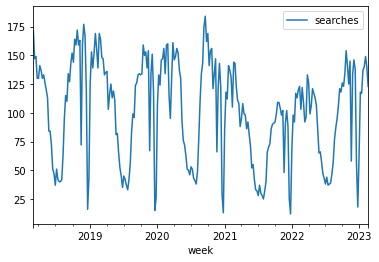

In [12]:
# assign a copy of temp_data to ts
ts = temp_data.copy()

# plot
ts.plot();

Let's zoom in on data from a single year (perhaps 2019) to see the plot for one year more clearly.

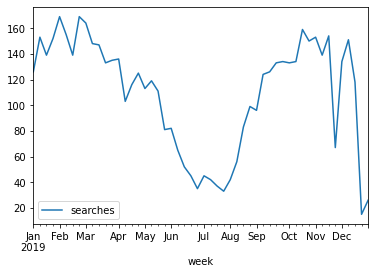

In [13]:
# plot weekly time series data for 2019
ts['2019-01-01':'2019-12-31'].plot();

I wonder why no one is thinking about polynomials in July? 🤪 (said no one ever)

Let's go back to the 5 year view, but make our data a little less granular first.

We can use Pandas time series `resample` function to get a monthly count for polynomial searches instead of our weekly count.

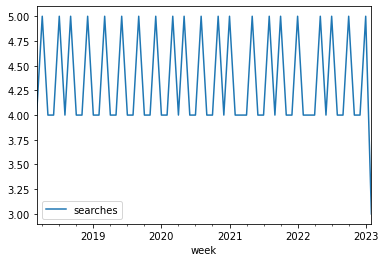

In [14]:
ts_monthly_count = ts.resample('MS').count()

ts_monthly_count.plot();

When we reduce the granularity of our count to monthly, a clear pattern emerges.

Let's also visualize this pattern using a heatmap.

In [15]:
# we have 5 years = 60 months of data
ts_monthly_count.shape

(60, 1)

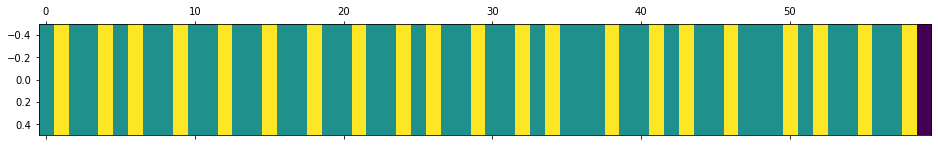

In [16]:
# transpose so that months are on the x-axis for readability
plt.matshow(ts_monthly_count.T, interpolation=None, aspect='auto');

To better visualize the pattern, let's again focus on one year, this time at the weekly level of granularity.

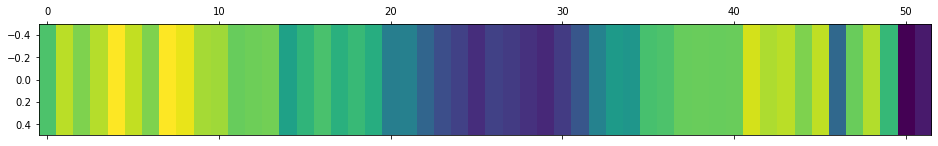

In [17]:
plt.matshow(ts['2019-01-01':'2019-12-31'].T, interpolation=None, aspect='auto');

Now we see the pattern for the year pretty clearly. In the first 15-ish weeks of the year (Jan - Mar), polynomials are being searched a lot; from the 20th to 30th weeks, there is much less search activity related to polynomials (this would be roughly end of May to mid-August.) We can even see two weeks of winter break there at the end of December. 😊

### Test for Stationarity

Our next task is to test for stationarity. Loosely speaking, are the (rolling) mean and variance stationary over time, and is covariance between time periods also constant?

One way to test for stationarity is to calculate the rolling mean and rolling standard deviation and see if they appear to be (close to) constant over time. Let's try using a window size of 4 which would correspond to the average / standard deviation of weekly searches over the course of 1 month.

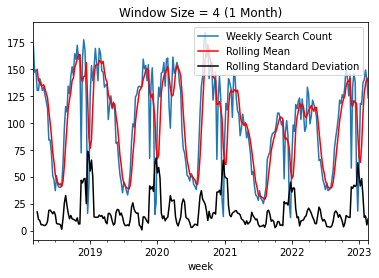

In [18]:
roll_mean = ts.rolling(window=4, center=False).mean()
roll_std = ts.rolling(window=4, center=False).std()

fig, ax = plt.subplots()

ts.plot(ax=ax)
roll_mean.plot(ax=ax, c='r')
roll_std.plot(ax=ax, c='k')
ax.legend(['Weekly Search Count', 'Rolling Mean', 'Rolling Standard Deviation'])
ax.set_title('Window Size = 4 (1 Month)');

Our data definitely does not look stationary. Variance increases and decreases over time (perhaps in a seasonal way?), and the mean varies over time as well in a seemingly periodic fashion.

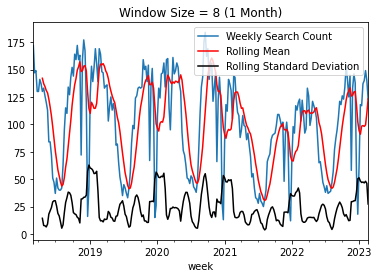

In [19]:
# out of curiosity, if we double the window size, what visual difference do we see?
roll_mean = ts.rolling(window=8, center=False).mean()
roll_std = ts.rolling(window=8, center=False).std()

fig, ax = plt.subplots()

ts.plot(ax=ax)
roll_mean.plot(ax=ax, c='r')
roll_std.plot(ax=ax, c='k')
ax.legend(['Weekly Search Count', 'Rolling Mean', 'Rolling Standard Deviation'])
ax.set_title('Window Size = 8 (1 Month)');

Doubling the window size doesn't make much of a difference.

One other way that we can test for stationarity is to apply the Dickey-Fuller test.

The null hypothesis for this statistical test is: The time series is *not* stationary.

I find this formulation of the null hypothesis awkward - it feels like a double negative to me - so I like to say that the alternative hypothesis is that the data is stationary.

In [21]:
from statsmodels.tsa.stattools import adfuller, kpss

results = adfuller(ts)
p_val = results[1]

if p_val < 0.01:
    print('Significant at the 99% confidence level - the data is stationary.')
elif p_val < 0.05:
    print('Significant at the 95% confidence level - the data is stationary.')
else:
    print('Not enough evidence to conclude that the data is stationary.')

Significant at the 99% confidence level - the data is stationary.


Honestly, this result suprises me. Maybe I don't really understand what a time series being stationary means. It looks to me like the time series above is *not* stationary.

Let me check the conditions of stationarity, and also the formulation of the Dickey Fuller hypothesis test.

I don't think that I am mistaken about either of these. Perhaps I am implementing the test incorrectly in Python.

In [22]:
# trying another statistical test for stationarity
kpss(ts)

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.23830648238013238,
 0.1,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

The null hypothesis for KPSS is trend-stationarity; so we get the same results with the other statistical test.

### Transform Data to Make Series Stationary

I'm not sure why the Dickey Fuller test is implying that the series is stationary, so I am going to continue on to transforming the data to make it stationary as if it weren't.

One option is to take the logarithm of the data. In this case, I don't think that this is actually a good technique because we don't have a clear "trend" (upward or downward linear / exponential / etc.), and I think this technique is most useful for removing trends rather than seasonality. But below, we see the results of plotting the logarithm of the time series values:

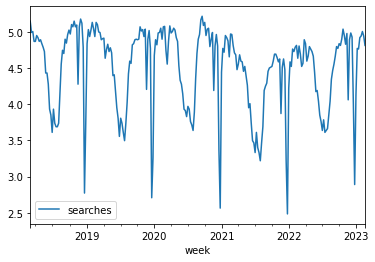

In [130]:
np.log(ts).plot();

Another option is to remove the rolling mean. The result of subtracting the rolling mean from each times series value is plotted below:

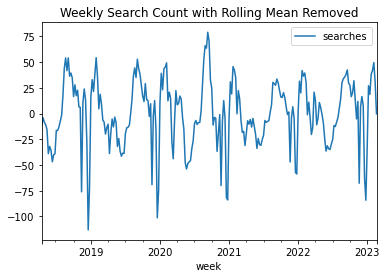

In [136]:
fig, ax = plt.subplots()
(ts - roll_mean).dropna().plot(ax=ax)
ax.set_title('Weekly Search Count with Rolling Mean Removed');

In all of these plots, be sure to pay attention to the *y*-axis. We have changed the range, not as much as we did with the log transformation, but significantly (for instance, we now have negative values.)

I think we will see the effect of subtracting the rolling mean more clearly in the monthly data.

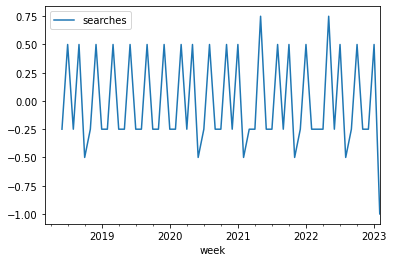

In [137]:
(ts_monthly_count - ts_monthly_count.rolling(window=4).mean()).plot();

This is quite close to being what *I* would consider stationary, though we still have large-ish deviations (depending on your definition of large.)

Let's also quickly try subtracting the weighted rolling mean (exponentially weighted rolling mean, in this case) to see if it makes a difference:

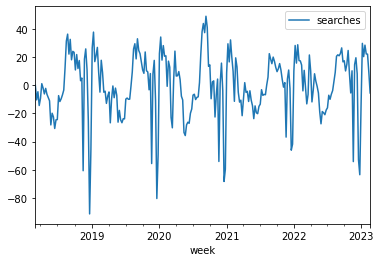

In [138]:
(ts - ts.ewm(halflife=2).mean()).plot();

It's a little better than the straight rolling mean in terms of a tighter range about 0, but not great.

A third option (besides log-transforming the data, or subtracting the rolling mean) is to "difference" the data.

I will do so with a period of 1, meaning that I find the difference between each time series value and the value in the previous period. So if the number of searches increases by 5 from week 2 to week 3, then the new value of the time series for period 3 would be 5.

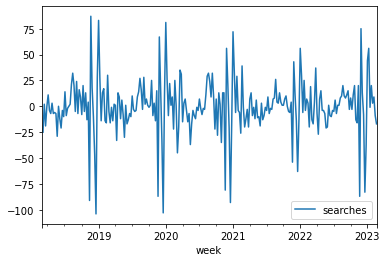

In [140]:
ts.diff().plot();

And of course, I'm just curious what the first difference of the monthly data looks like.

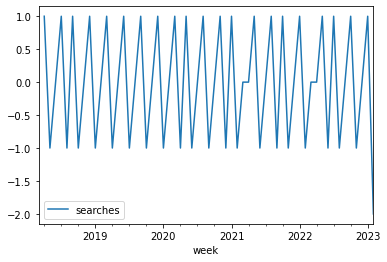

In [141]:
ts_monthly_count.diff(periods=1).plot();

Finally, we can try a combination of the above techniques. What if I take the first difference of the log-transformed time series?

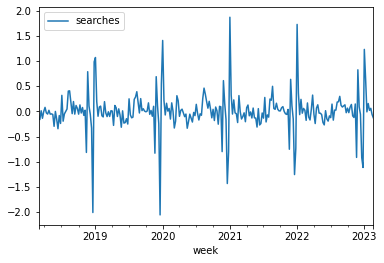

In [144]:
(np.log(ts)).diff().plot();

Let's compare to the monthly data.

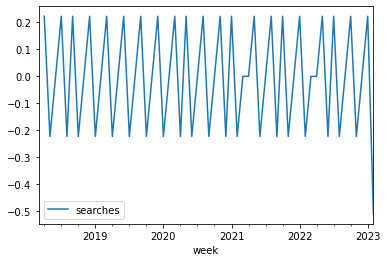

In [145]:
(np.log(ts_monthly_count)).diff().plot();

Can we get the weekly data less variable with two differences?

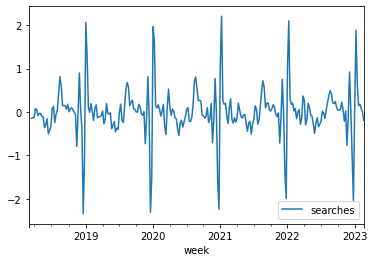

In [146]:
(np.log(ts)).diff(periods=2).plot();

What about with a combination of taking the logarithm and subtracting the rolling mean?

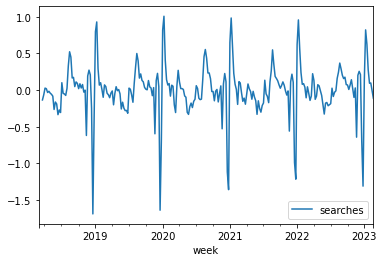

In [147]:
# take log first, then get rolling mean and subtract
log_ts = np.log(ts)
log_roll_mean = log_ts.rolling(window=4).mean()
(log_ts - log_roll_mean).plot();

It seems that, no matter what I do, there is this seasonality to the data. Let's try one last method: seasonally decomposing the data.

I am a little wary of this method because I don't fully understand it yet (and there is a note in the documentation suggesting that you use a less naive implementation of this algorithm! 😳) but let's see what we can accomplish with this method applied to our data.

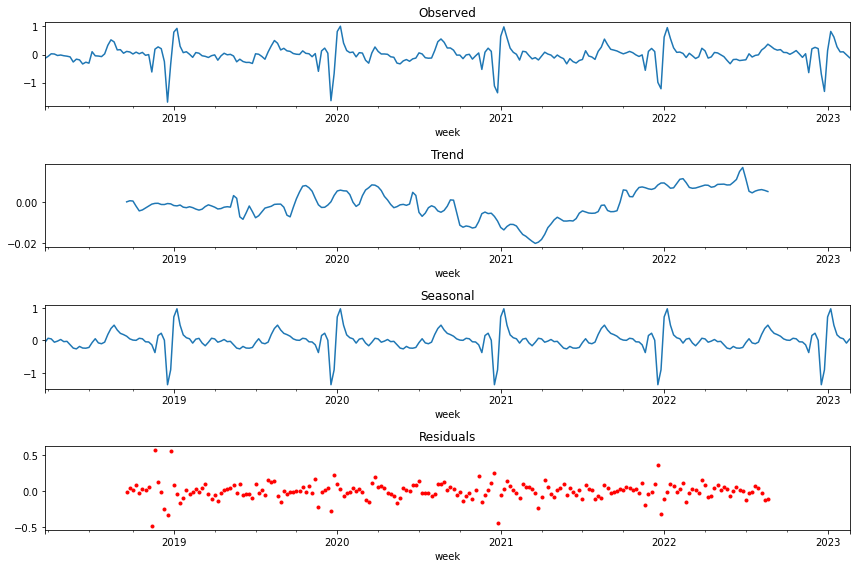

In [163]:
# import from statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose our log-transformed data with rolling mean subtracted
decomposition = seasonal_decompose((log_ts - log_roll_mean).dropna())

# plot results
fig, ax = plt.subplots(figsize=(12, 8), nrows=4)

decomposition.observed.plot(ax=ax[0])
ax[0].set_title('Observed')
decomposition.trend.plot(ax=ax[1])
ax[1].set_title('Trend')
decomposition.seasonal.plot(ax=ax[2])
ax[2].set_title('Seasonal')
decomposition.resid.plot(ax=ax[3], style='.', c='r')
ax[3].set_title('Residuals')
fig.tight_layout();

While I'm still wary of this decomposition, those residuals *look* pretty normally distributed about 0 (with a standard deviation less than 1!)

One thing that looks a little odd is the trend. I'm not really expecting there to be a trend with this data. With that being said, I failed to follow my own advice and look at the *y*-axis; the "trend" is pretty slight.

----

In summary,

**analysis**
the time series we analyzed here looked pretty much as expected in our original analysis with a sharp decrease in searches for polynomials over the summer and winter breaks.

**stationarity tests**
I still have some questions about stationarity, and in particular, about the Dickey Fuller test. Why is the Dickey Fuller test suggesting that my original data is stationary, when it clearly exhibits seasonality (in particular, the rolling mean is not constant with a window size of 4 weeks, though it is periodic)?

**transformations to achieve stationarity**
Lastly, the seasonal decomposition I did seems to reveal that our "log transformed with rolling mean removed series" is pretty much all seasonal. Should interpret this as a success, because the seasonality is contained between -1 and 1 with a mean of 0, or a failure, because the transformed series still has a seasonal trend of some kind?